# VEP SDE CDE Example (84 Regions)
This notebook demonstrates simulation and inference for the VEP (Virtual Epileptic Patient) stochastic differential equation (SDE) model with 84 brain regions. It covers:
- Setting up the model and parameters for healthy, propagation, and epileptic zones.
- Running simulations and extracting features from the generated time series.
- Performing parameter inference using a conditional density estimator (MAF).
- Visualizing posterior samples and comparing observed vs predicted dynamics.

The workflow is suitable for large-scale brain network modeling and probabilistic parameter estimation.

In [1]:
import os
import tqdm
import pickle
import numpy as np
import networkx as nx
from os.path import join
from vbi import report_cfg
import matplotlib.pyplot as plt
from vbi.cde import MAFEstimator
from vbi.utils import LoadSample
from vbi.plot import pairplot_numpy
from vbi.models.numba.vep import VEP_sde
from sklearn.preprocessing import StandardScaler

In [2]:
seed = 2
np.random.seed(seed)
path = "output/vep84"
os.makedirs(path, exist_ok=True)

In [3]:
weights = np.loadtxt("data/weights1.txt")
nn = weights.shape[0]

healthy zone, propagation zone, epileptic zone eta values

In [4]:
hz_val = -3.65
pz_val = -2.4
ez_val = -1.6

In [5]:
ez_idx = np.array([6, 34], dtype=np.int32)
pz_wplng_idx = np.array([5, 11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [6]:
initial_state = np.zeros(2 * nn)
initial_state[:nn] = -2.5
initial_state[nn:] = 3.5

In [7]:
params = {
    "G": 1.0,
    "seed": seed,
    "initial_state": initial_state,
    "weights": weights,
    "tau": 90.0,
    "eta": -3.5,
    "sigma": 0.0,
    "iext": 3.1,
    "dt": 0.1,
    "t_end": 80.0,
    "t_cut": 1.0,
    "record_step": 1,
    "method": "heun",
    "output": "output",
}

In [8]:
obj = VEP_sde(params)
g_true = 1.0
eta_true = np.ones(nn) * hz_val
eta_true[pz_idx] = pz_val
eta_true[ez_idx] = ez_val
control_true = {"eta": eta_true, "G": g_true}
theta_true = np.hstack(([g_true], eta_true))
theta_true.shape

(85,)

In [9]:
data = obj.run(par=control_true)
ts = data["x"]
t = data["t"]
t.shape, ts.shape

((790,), (84, 790))

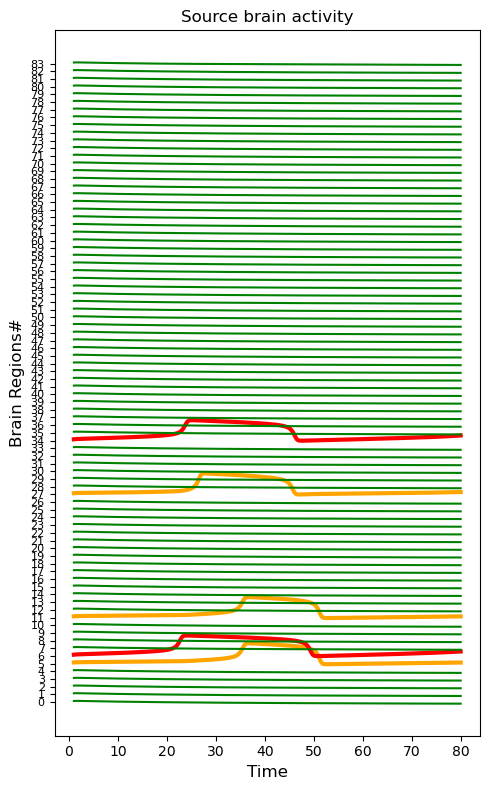

In [10]:

plt.figure(figsize=(5, 8))
for i in range(0, nn):
    if i in ez_idx:
        plt.plot(t, ts[i, :] + i, "r", lw=3)
    elif i in pz_idx:
        plt.plot(t, ts[i, :] + i, "orange", lw=3)
    else:
        plt.plot(t, ts[i, :] + i, "g")
plt.yticks(np.r_[0:nn] - 2, np.r_[0:nn], fontsize=8)
plt.title("Source brain activity", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Brain Regions#", fontsize=12)
plt.tight_layout()

In [11]:
from vbi.feature_extraction.features_settings import *
from vbi.feature_extraction.calc_features import *

In [12]:
fs = 1 / (params["dt"]) / 1000
cfg = get_features_by_domain(domain="statistical")
# cfg = get_features_by_given_names(cfg, names=["calc_moments"])
cfg = get_features_by_given_names(cfg, names=["auc"])
report_cfg(cfg)

Selected features:
------------------
■ Domain: statistical
 ▢ Function:  auc
   ▫ description:  Computes the area under the curve of the signal computed with trapezoid rule.
   ▫ function   :  vbi.feature_extraction.features.auc
   ▫ parameters :  {'dx': None, 'x': None, 'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes


In [13]:
data = extract_features_df([ts], fs, cfg=cfg, n_workers=1)
print(data.values.shape)

100%|██████████| 1/1 [00:00<00:00, 731.73it/s]

(1, 84)


In [14]:
def wrapper(params, control, x0, cfg, verbose=False):
    vep_obj = VEP_sde(params)
    sol = vep_obj.run(control, x0=x0)

    # extract features
    fs = 1.0 / params["dt"] * 1000  # [Hz]
    stat_vec = extract_features(
        ts=[sol["x"]], cfg=cfg, fs=fs, n_workers=1, verbose=verbose
    ).values[0]
    return stat_vec

In [15]:
def batch_run(params, control_list, x0, cfg, n_workers=1):
    n = len(control_list)
    def update_bar(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm.tqdm(total=n) as pbar:
            async_results = [
                pool.apply_async(
                    wrapper,
                    args=(params, control_list[i], x0, cfg, False),
                    callback=update_bar,
                )
                for i in range(n)
            ]
            stat_vec = [res.get() for res in async_results]
    return stat_vec

In [16]:
x_ = wrapper(params, control_true, initial_state, cfg)
print(x_.shape)

(84,)


In [17]:
num_sim = 10_000
num_workers = 10
eta_min, eta_max = -5.0, -1.0
gmin, gmax = 0.0, 2.0

In [18]:
from vbi.utils import BoxUniform

prior_min = [gmin] + [eta_min] * nn
prior_max = [gmax] + [eta_max] * nn
prior = BoxUniform(low=prior_min, high=prior_max, seed=seed)
theta = prior.sample((num_sim))

In [20]:
control_list = [{'eta': theta[i, 1:], "G": theta[i, 0]} for i in range(num_sim)]

In [21]:
stat_vec = batch_run(params, control_list, initial_state, cfg, num_workers)

100%|██████████| 10000/10000 [00:34<00:00, 292.08it/s]


In [22]:
scalar = StandardScaler()
stat_vec = scalar.fit_transform(np.array(stat_vec))
np.savez(join(path, "data.npz"), theta=theta, stat_vec=stat_vec)

In [24]:
xo = wrapper(params, control_true, initial_state, cfg)
xo = scalar.transform(xo.reshape(1, -1))
print(theta_true.shape, xo.shape)

np.savez(join(path, "data_xo.npz"), theta=theta_true, xo=xo)

(85,) (1, 84)


In [27]:
import autograd.numpy as anp
rng = anp.random.RandomState(seed)
maf_estimator = MAFEstimator(n_flows=10, hidden_units=128)
maf_estimator.train(theta, stat_vec, n_iter=1000, learning_rate=2e-4)
print("best epoch:", maf_estimator.best_epoch, "best val:", maf_estimator.best_val_loss)
samples = maf_estimator.sample(xo, n_samples=5000, rng=rng)[0]

Inferred dimensions: param_dim=85, feature_dim=84


Training:  50%|████▉     | 498/1000 [16:43<16:51,  2.02s/it, patience=20/20, train=-117.2929, val=-64.1351]


best epoch: 478 best val: -64.72335052490234


In [28]:
with open(join(path, "posterior.pkl"), "wb") as f:
    pickle.dump(maf_estimator, f)
# with open(join(path, "posterior.pkl"), "rb") as f:
#     maf_estimator = pickle.load(f)

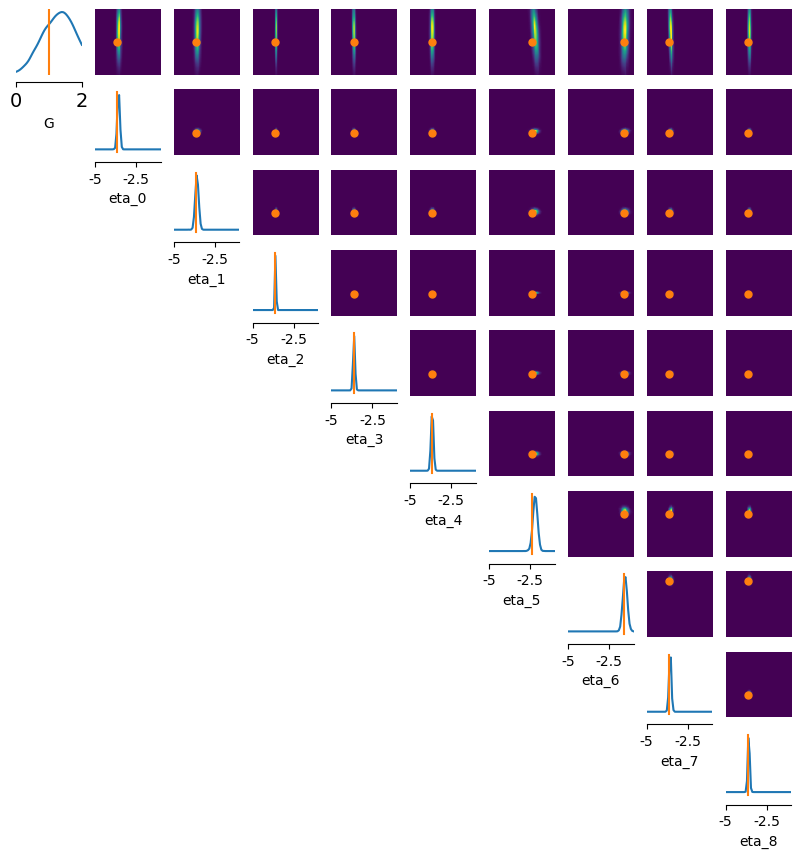

In [30]:
limits = [[i, j] for i, j in zip(prior_min[:10], prior_max[:10])]
points = np.array([[g_true] + eta_true[:10].tolist()])
fig, ax = pairplot_numpy(
    samples[:, :10],
    limits=limits,
    figsize=(10, 10),
    points=points.reshape(1, -1),
    labels=["G"]+ [f"eta_{i}" for i in range(9)],
    offdiag="kde",
    diag="kde",
    points_colors="r",
    samples_colors="k",
    points_offdiag={"markersize": 10},
)
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].margins(y=0)
fig.savefig(join(path, "triangleplot.jpeg"), dpi=300)

In [31]:
def plot_eta(samples, eta_true, ax):
    prior = np.random.uniform(-5, -1, size=(10000, 1))
    positions = np.arange(1, eta_true.shape[0]+1)
    parts = ax.violinplot(samples, positions=positions, widths=0.7, showmeans=1, showextrema=1)
    ax.plot(np.r_[1:eta_true.shape[0]+1], eta_true, 'o', color='g', alpha=0.9, ms=6)

    parts_prior = ax.violinplot(prior, positions=[0],  widths=0.7, showmeans=1, showextrema=1)

    ax.set_ylabel('Density ' + r'${\eta_i}$', fontsize=18)
    ax.set_xlabel('Regions', fontsize=18)
    ax.tick_params(labelsize=14)
    
    for pc in parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('k')
        pc.set_alpha(0.5)
        pc.set_linewidth(0.5)
    for pc in parts_prior['bodies']:
        pc.set_facecolor('blue')
        pc.set_edgecolor('k')
        pc.set_alpha(0.5)
        pc.set_linewidth(0.5)

    parts['cbars'].set_color('k')
    parts['cbars'].set_linewidth(1)
    parts_prior['cbars'].set_color('k')
    parts_prior['cbars'].set_linewidth(1)


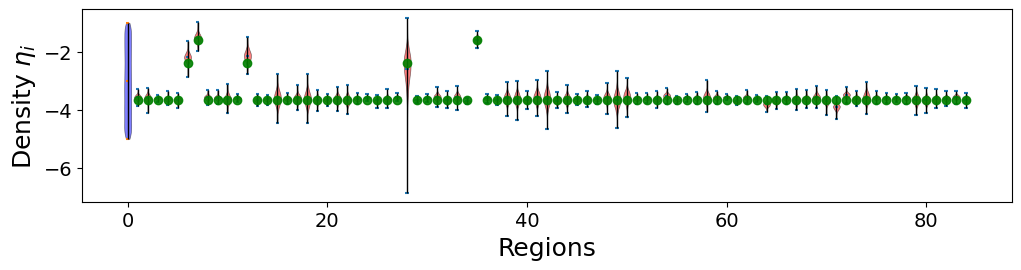

In [35]:
fig, ax = plt.subplots(1, figsize=(12, 2.5))
plot_eta(samples[:, 1:], eta_true, ax)

In [36]:
from vbi.utils import posterior_peaks_numpy

peaks = posterior_peaks_numpy(samples)

In [37]:
c_obs = {"eta": eta_true, "G": g_true}
c_ppc = {"eta": peaks[1:], "G": peaks[0]}

In [38]:
obj = VEP_sde(params)
data_obs = obj.run(par=c_obs)
data_ppc = obj.run(par=c_ppc)

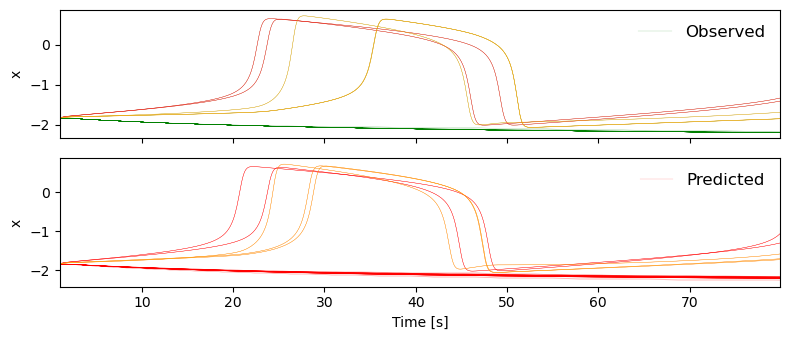

In [39]:
fig, ax = plt.subplots(2, figsize=(8, 3.5), sharex=True)
ax[0].plot(data_obs["t"], data_obs["x"].T, "g", lw=0.1)
ax[0].plot(data_obs["t"], data_obs['x'][ez_idx].T, "r", lw=0.3)
ax[0].plot(data_obs["t"], data_obs['x'][pz_idx].T, "orange", lw=0.3)
ax[1].plot(data_ppc["t"], data_ppc["x"].T, "r", lw=0.1);
ax[1].plot(data_ppc["t"], data_ppc['x'][ez_idx].T, "r", lw=0.3)
ax[1].plot(data_ppc["t"], data_ppc['x'][pz_idx].T, "orange", lw=0.3)
ax[0].legend(['Observed'], loc="upper right", fontsize=12, frameon=False)
ax[1].legend(['Predicted'], loc="upper right", fontsize=12, frameon=False)
ax[1].set_xlabel("Time [s]");
ax[0].set_ylabel(r"x");
ax[1].set_ylabel(r"x");
ax[0].margins(x=0)
fig.tight_layout()
plt.savefig(join(path, "observed_vs_predicted.png"), dpi=300);

In [40]:
np.savez(join(path, "data_ppc.npz"), 
         peaks=peaks,
         t=data_obs["t"], 
         x_obs=data_obs["x"], x_ppc=data_ppc["x"], 
         eta_true=[g_true] + eta_true.tolist()
         )

In [41]:
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy

sh = posterior_shrinkage_numpy(theta, samples)
zs = posterior_zscore_numpy(np.array([g_true] + eta_true.tolist()), samples)

In [42]:
np.savez(join(path, "shrinkage_zscore.npz"), sh=sh, zs=zs)

In [43]:
auc_obs = wrapper(params, c_obs, initial_state, cfg, verbose=True)
auc_ppc = wrapper(params, c_ppc, initial_state, cfg, verbose=True)

100%|██████████| 1/1 [00:00<00:00, 1171.59it/s]


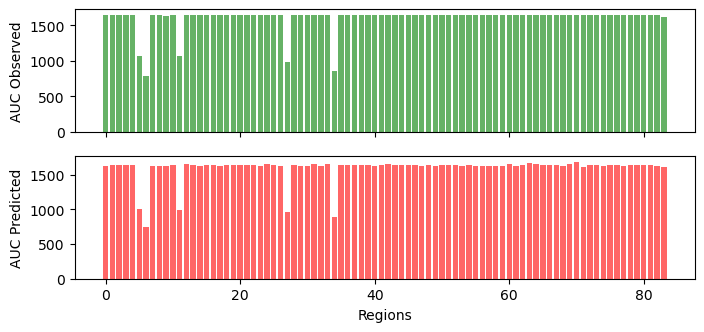

In [44]:
# bar plot auc_obs 
fig, ax = plt.subplots(2, figsize=(8, 3.5), sharex=True)
ax[0].bar(np.arange(auc_obs.shape[0]), -auc_obs, color='g', alpha=0.6)
ax[1].bar(np.arange(auc_ppc.shape[0]), -auc_ppc, color='r', alpha=0.6);
ax[1].set_xlabel("Regions");
ax[0].set_ylabel(r"AUC Observed");
ax[1].set_ylabel(r"AUC Predicted");
plt.savefig(join(path, "auc_observed_vs_predicted.png"), dpi=300);

In [45]:
np.savez(join(path, "auc.npz"), auc_obs=auc_obs, auc_ppc=auc_ppc)